# Dependencies
Install **anaconda** is recommended

| Name             | Version | Numpy & Python Version   |             |
| ---------------- |---------|--------------------------|-------------|
| cassandra-driver | 3.11.0  |      py35_1              | conda-forge |
| pandas           | 0.19.1  | np111py35_0              |             | 
| scikit-learn     | 0.18.1  | np111py35_0              |             |
| scipy            | 0.18.1  | np111py35_0              |             |
| matplotlib       | 2.0.0   | np111py35_0              |             |

In [ ]:
'''
commands.
'''

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
'''
Parameters. 
Parameters that are defined in this cell can be injected and overwritten by the machine learning platform.
'''

# MLP defined parameters 
training_runner = None
project_id = None
training_id = None
metrics_feedback_url = None
model_destination = None

# user defined parameters

# label keys
label = 'success'
# model file directory
work_dir = '/var/spark/ml_files/'
model_type = 'ML-BPR'
start_date = '2019-01-01'
end_date = '2019-05-31'

# data
training_data = work_dir + 'processor_retry_2019_06.csv'
bin_profile_data =  work_dir + 'bin_profile_2019_01_to_2019_05.csv'
payment_mid_bin_data = work_dir + 'payment_mid_bin_2019_01_to_05.csv'
decline_type_data = work_dir + 'Decline_Type.csv'

# features
input_features = {
    'billing_country': {
        'type': 'string'
    },
    'bin': {
        'type': 'string'
    },
    'card_brand': {
        'type': 'string'
    },
    'card_category': {
        'type': 'string'
    },
    'card_class': {
        'type': 'string'
    },
    'card_usage': {
        'type': 'string'
    },
    'cc_expiration_date': {
        'type': 'string'
    },
    'day_of_month': {
        'type': 'integer'
    },
    'failed_attempt_date': {
        'type': 'string'
    },
    'failed_response_code': {
        'type': 'string'
    },
    'failed_response_message': {
        'type': 'string'
    },
    'funding_source': {
        'type': 'string'
    },
    'issuer_country': {
        'type': 'string'
    },
    'merchant_number': {
        'type': 'string'
    },
    'payment_amount_usd': {
        'type': 'number'
    },
    'payment_currency': {
        'type': 'string'
    },
    'payment_method_id': {
        'type': 'string'
    },
    'payment_service_id': {
        'type': 'string'
    },
    'renew_att_num': {
        'type': 'integer'
    },
    'site_id': {
        'type': 'string'
    },
    'transaction_date_in_string': {
        'type': 'string'
    },
    'failed_cid': {
        'type': 'string'
    },
    'failed_payment_service_id': {
        'type': 'string'
    },
    'processor_att_num': {
        'type': 'integer'
    },
    'merchant_descriptor': {
        'type': 'integer'
    },
    'bank_name': {
        'type': 'integer'
    },
    'transaction_hour': {
        'type': 'integer'
    }
}
features_cat = [
    'card_category', 
    'issuer_country', 
    'merchant_number', 
    'merchant_descriptor', 
    'bank_name', 
    'payment_service_id', 
    'bin', 
    'failed_payment_service_id', 
    'payment_currency', 
    'day_of_month', 
    'failed_response_code', 
    'failed_decline_type', 
    'transaction_hour', 
    'failed_cid'
]
features_num = [
    'payment_amount_usd'
]
features_float = [
    'bin', 
    'renew_att_num', 
    'failed_response_code'
]
features_num_calculated = []
features_encoded = [
    'week_of_month', 
    'day_of_week', 
    'is_expired'
]
features_num_encoded = [
    'payment_mid_bin'
]

# hyperparameters
tuned_parameters = None
best_parameters = {
    'objective': 'binary:logistic',
    'learning_rate': 0.15, #0.1, #so called `eta` value
    'max_depth': 10,
    'min_child_weight': 6,
    'silent': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8, #0.8,
     # 'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
    'n_estimators': 1000, #500, #number of trees, change it to 1000 for better results  
    'missing':-999,
    'max_delta_step': 1,
    'seed': 1337,
    'scale_pos_weight': 1,
    'gamma': 3 
}

In [ ]:
'''
print out all parameters.
'''

print('training_runner', training_runner)
print('project_id =', project_id)
print('training_id =', training_id)
print('metrics_feedback_url =', metrics_feedback_url)
print('model_destination =', model_destination)
print('label =', label)
print('training_data =', training_data)
print('bin_profile_data =', bin_profile_data)
print('payment_mid_bin_data =', payment_mid_bin_data)
print('decline_type_data =', decline_type_data)
print('input_features =', input_features)
print('features_cat =', features_cat)
print('features_float =', features_float)
print('features_num =', features_num)
print('features_num_calculated = ', features_num_calculated)
print('features_num_encoded = ', features_num_encoded)
print('features_encoded =', features_encoded)
print('tuned_parameters =', tuned_parameters)
print('best_parameters =', best_parameters)

In [1]:
'''
imports.
'''

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np

if training_runner is None:
    # from cassandra
    from cassandra.cluster import Cluster
    cassandra_endpoint = '10.62.1.118'
    cluster = Cluster([cassandra_endpoint])
    
# import for training
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import cross_validation
from sklearn import ensemble
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV

# from training import PreProcessing
# from sklearn.pipeline import make_pipeline
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer
from src.web.train_util import *
from xgboost import XGBClassifier
# import xgboost as xgb
from sklearn.externals import joblib

NameError: name 'training_runner' is not defined

In [1]:
'''
configurations.
'''

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100

In [4]:
'''
training data manipulation.
'''

retry_success =  pd.read_csv(training_data)
retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(308719, 57)

In [5]:
'''
bin profile data manipulation.
'''

bin_profile = None
if bin_profile_data:
    bin_profile = pd.read_csv(bin_profile_data)
    bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
    bin_profile.shape

In [ ]:
'''
payment mid bin data manipulation.
'''

payment_mid_bin_dict = None
if payment_mid_bin_data:
    payment_mid_bin = pd.read_csv(payment_mid_bin_data)
    payment_mid_bin['bin'] = payment_mid_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    payment_mid_bin_dict = payment_mid_bin.set_index(['bin', 'payment_service_id', 'merchant_number'])['success_rate'].T.to_dict()

In [ ]:
'''
decline type data manipulation.
'''

df_decline_type = pd.read_csv(decline_type_data)

In [6]:
original_size = len(retry_success)
fail_size = retry_success[label].value_counts(normalize=True)[0.0]
success_size =  retry_success[label].value_counts(normalize=True)[1.0]

In [10]:
'''
feature manipulation and aggregation.
'''

features = features_cat + features_encoded

fields = features_cat + features_num + ['transaction_date_in_string', 'cc_expiration_date',  'failed_cc_expiration_date', 'billing_country']

features_dict = {
    'LABEL': label, 
    'FIELDS': fields ,
    'FEATURES_CAT': features_cat, 
    'FEATURES_NUM':features_num, 
    'FEATURES_ENCODED':features_encoded, 
    'FEATURES_NUM_ENCODED':features_num_encoded, 
    'FEATURES_NUM_CALCULATED':features_num_calculated, 
    'FEATURES_FLOAT': features_float
}
features_dict_key = 'preprocessing__features_dict'
features_dict['df_bin_profile'] = bin_profile
features_dict['df_decline_type'] = df_decline_type
features_dict['payment_mid_bin_dict'] = payment_mid_bin_dict


--------------------
(9000, 20)
(9000,)
(1000, 20)
(1000,)
## bin_profile: (32843, 12)
# df_bin_profile: (32843, 12)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
self.features_encoded: ['week_of_month', 'day_of_week', 'is_expired']
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["payment_mid_bin"] = df.apply(self.payment_mid_bin_util.payment_mid_bin, axis=1)


self.features_all:  ['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_response_code', 'failed_decline_type', 'transaction_hour', 'failed_cid', 'week_of_month', 'day_of_week', 'is_expired', 'payment_amount_usd', 'payment_mid_bin']
In fit, self.features_cat_and_encoded: ['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_response_code', 'failed_decline_type', 'transaction_hour', 'failed_cid', 'week_of_month', 'day_of_week', 'is_expired']
['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_respo

/var/spark/jupyter-notebooks/src/web/preprocessing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["failed_merchant_number"] = df.apply(self.convert_failed_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["payment_mid_bin"] = df.apply(self.payment_mid_bin_util.payment_mid_bin, axis=1)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


# transform_time: 10.566193580627441
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 4 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 8 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 8 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 4 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 12 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 4 pruned nodes, max_depth=10
[07:00:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 10 pruned nodes, max_depth=10
[07:00:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 ext

[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=10
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 28 pruned nodes, max_depth=10
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 38 pruned nodes, max_depth=7
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 46 pruned nodes, max_depth=9
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 42 pruned nodes, max_depth=8
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 30 pruned nodes, max_depth=10
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 34 pruned nodes, max_depth=6
[07:00:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=10
[07:

[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 40 pruned nodes, max_depth=3
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 34 pruned nodes, max_depth=6
[07:00:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=9
[07:00:38] 

[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 22 pruned nodes, max_depth=6
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 38 pruned nodes, max_depth=4
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 30 pruned nodes, max_depth=5
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 30 pruned nodes, max_depth=4
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 24 pruned nodes, max_depth=5
[07:00:39] /w

[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[07:00:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:40] /work

[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 34 pruned nodes, max_depth=4
[07:00:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[07:00:40] /work

[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:41] /work

[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 28 pruned nodes, max_depth=2
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:42] /work

[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 32 pruned nodes, max_depth=2
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 30 pruned nodes, max_depth=2
[07:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=6
[07:00:43] /wor

[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 30 pruned nodes, max_depth=3
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 30 pruned nodes, max_depth=3
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 32 pruned nodes, max_depth=3
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:44] /work

[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:44] /work

[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 26 pruned nodes, max_depth=5
[07:00:45] /wor

[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[07:00:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:46] /wor

[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[07:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[07:00:47] /work

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/var/spark/jupyter-notebooks/src/web/preprocessing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 6, 'silent': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 1000, 'missing': -999, 'max_delta_step': 1, 'seed': 1337, 'scale_pos_weight': 49.91852218373742, 'gamma': 3}
x_train (9000, 24)
x_test (1000, 20)
x_train  .....                      card_category issuer_country  \
4896                Visa Business             BR   
4782                 Visa Classic             CL   
1496             Visa Traditional             US   
1957     Platinum MasterCard Card             US   
9171  Debit MasterCard (Enhanced)             US   

                           merchant_number   merchant_descriptor  \
4896  75FA81DE-5AC5-5DCF-E97C-8F80A08ADE1E      DRI*Avast Brazil   
4782                            1411163460    DRI*AVAST Software   
1496                               7236114    DRI*AVAST Software   
1957                               7236114  DRI*AVG Technologies   


/var/spark/jupyter-notebooks/src/web/preprocessing.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["failed_merchant_number"] = df.apply(self.convert_failed_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# Finish handle_feat_encoded.
# transform_time: 2.980556011199951
# training time: 34.104466915130615
x_train:                     card_category issuer_country  \
4896                Visa Business             BR   
4782                 Visa Classic             CL   
1496             Visa Traditional             US   
1957     Platinum MasterCard Card             US   
9171  Debit MasterCard (Enhanced)             US   

                           merchant_number   merchant_descriptor  \
4896  75FA81DE-5AC5-5DCF-E97C-8F80A08ADE1E      DRI*Avast Brazil   
4782                            1411163460    DRI*AVAST Software   
1496                               7236114    DRI*AVAST Software   
1957                               7236114  DRI*AVG Technologies   
9171                               7236114  DRI*AVG Technologies   

                                         bank_name payment_service_id     bin  \
4896                          Banco Santander S.A.            pagador  457938   
4782 

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


model_file is generated:  ['/var/spark/ml_files/models/ML-BPR-2.2.pkl']
result_dict:  {'hyper_params': {'objective': 'binary:logistic', 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 6, 'silent': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 1000, 'missing': -999, 'max_delta_step': 1, 'seed': 1337, 'scale_pos_weight': 49.91852218373742, 'gamma': 3}, 'training_time': 34.104466915130615, 'accuracy_dummy': 0.98, 'train_accuracy': 0.998, 'test_accuracy': 0.975, 'train_class_report': '             precision    recall  f1-score   support\n\n          0       1.00      1.00      1.00      8813\n          1       0.91      1.00      0.95       187\n\navg / total       1.00      1.00      1.00      9000\n', 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      0.99      0.99       980\n          1       0.37      0.35      0.36        20\n\navg / total       0.97      0.97      0.97      1000\n', 'feature_importanc

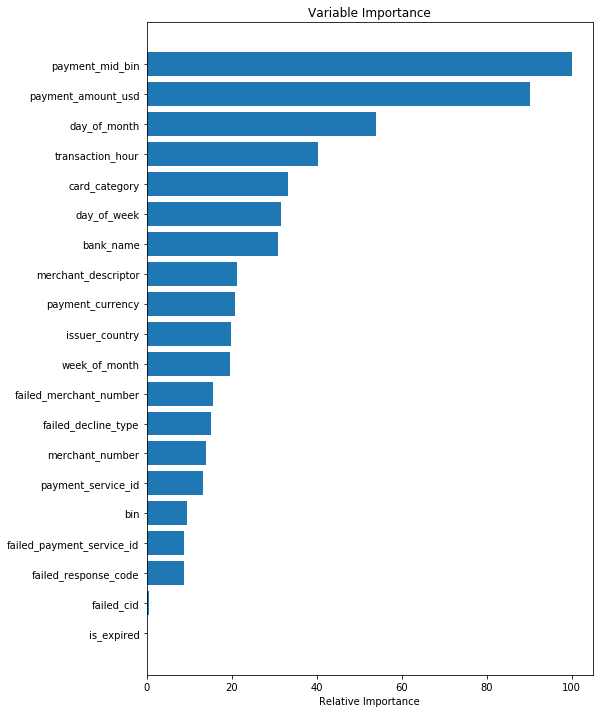

In [11]:
'''
train the model with xgboost classifier
'''

classifier = XGBClassifier
scale_pos_weight = fail_size / success_size
best_parameters['scale_pos_weight'] = scale_pos_weight

model_file = ''
features_dict['eval_metric'] = 'map'
xgb_clf, result_d = build_and_train(
    retry_success, 
    classifier, 
    tuned_parameters, 
    'xgbclassifier', 
    model_file, 
    best_param=best_parameters, 
    features_dict=features_dict
)
print('result_dict: ', result_d)

In [ ]:
'''
output the model
'''

if training_runner is None:
    from src.web.model_info_repository import get_latest_version
    model_id = 'ML-BPR-2'
    version = get_latest_version(model_id, model_type) + 1
    model_name = model_id + '.' + str(version)
    model_file, model_file_name = write_model(xgb_clf, model_name)
else:
    model_file = joblib.dump(xgb_clf, model_destination)

print('model_file generated: ', model_file)

In [13]:
# """Upload model to Nexus repo and insert the model info into Cassandra table"""
# import json

# start_date = '2018-01-01'
# # start_date = '2019-01-01'
# # start_date = '2019-01-01'

# # end_date = '2019-03-31'
# end_date = '2019-05-31'


# try:
#     repo_path = upload_artifact(model_file_name)
#     preprocess_repo_path = handle_preprocessing_file(model_id, version)
#     size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
#     desc = '{}_{}_for_processor retry model. {}'.format(start_date, end_date, size_desc)
#     hyper_params = result_d.pop('hyper_params', None)
#     extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
#     insert_model_info(model_id, version, repo_path, desc=desc, model_type=MODEL_TYPE,eval_metrics=json.dumps(result_d), 
#                       hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att), features_dict=features_dict)
    
# except:
#     if not hyper_params:
#         result_d['hyper_params'] = hyper_params 